In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [4]:
wines = pd.read_csv('../data/Wines2012.csv', sep=';',
                    names='judge,flight,wine,score,wine_amer,judge_amer'.split(','),
                    skiprows=1)
wines = wines.assign(flight_red = (wines.flight == 'red').astype('int'))

wines.sample(5)

,judge,flight,wine,score,wine_amer,judge_amer,flight_red
76,Jamal Rayyis,white,G1,12.0,1,0,0
155,Daniele Meulder,red,F2,15.0,1,0,1
158,Daniele Meulder,red,I2,10.0,1,0,1
41,Robert Hodgson,white,B1,11.0,1,1,0
141,Linda Murphy,red,B2,14.0,0,1,1


In [7]:
with pm.Model() as m_01:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(2, 2, 2))

    score_i = pm.Deterministic(
        'score',
        wines.score.mean()
        + beta[tuple([wines.wine_amer.values,
                      wines.judge_amer.values,
                      wines.flight_red.values])]
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    score_obs = pm.Normal('score_obs', mu=score_i, sd=sigma,
                          observed=wines.score.values)
    
    m_01.name = 'full interaction'
    m_01.trace = pm.sample(5000, tune=1000, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
/home/petrushev/etc/jup_env/lib/python3.7/site-packag

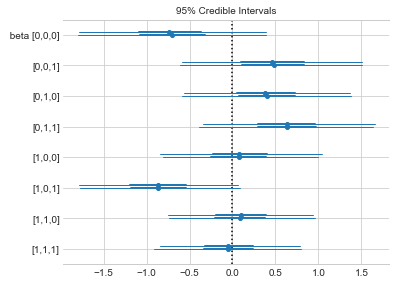

In [8]:
pm.forestplot(m_01.trace, varnames=['beta'], rhat=False)
None

In [13]:
with pm.Model() as m_02:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1, shape=3)
    beta2 = pm.Normal('beta2', mu=0, sd=1, shape=3)
    beta3 = pm.Normal('beta3', mu=0, sd=1)

    score_i = pm.Deterministic(
        'score',
        wines.score.mean()
        + alpha
        + beta1[0] * wines.wine_amer.values
        + beta1[1] * wines.judge_amer.values
        + beta1[2] * wines.flight_red.values
        + beta2[0] * (wines.wine_amer.values * wines.judge_amer.values)
        + beta2[1] * (wines.wine_amer.values * wines.flight_red.values)
        + beta2[2] * (wines.judge_amer.values * wines.flight_red.values)
        + beta3 * (wines.wine_amer.values * wines.judge_amer.values * wines.flight_red.values)
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    score_obs = pm.Normal('score_obs', mu=score_i, sd=sigma,
                          observed=wines.score.values)
    
    m_02.name = 'full interaction, v2'
    m_02.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:32<00:00, 368.16draws/s]


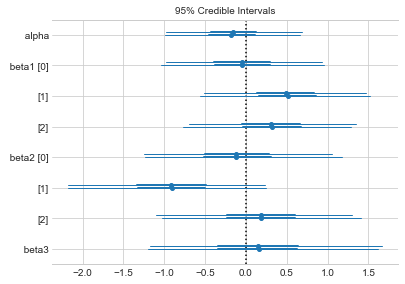

In [15]:
pm.forestplot(m_02.trace,
              varnames=['alpha', 'beta1', 'beta2', 'beta3'],
              rhat=False)
None

In [17]:
with pm.Model() as m_03:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1, shape=2)
    beta2 = pm.Normal('beta2', mu=0, sd=1, shape=3)
    beta3 = pm.Normal('beta3', mu=0, sd=1)

    score_i = pm.Deterministic(
        'score',
        wines.score.mean()
        + alpha
        + beta1[0] * wines.judge_amer.values
        + beta1[1] * wines.flight_red.values
        + beta2[0] * (wines.wine_amer.values * wines.judge_amer.values)
        + beta2[1] * (wines.wine_amer.values * wines.flight_red.values)
        + beta2[2] * (wines.judge_amer.values * wines.flight_red.values)
        + beta3 * (wines.wine_amer.values * wines.judge_amer.values * wines.flight_red.values)
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    score_obs = pm.Normal('score_obs', mu=score_i, sd=sigma,
                          observed=wines.score.values)
    
    m_03.name = 'full interaction, v3'
    m_03.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:29<00:00, 400.44draws/s]


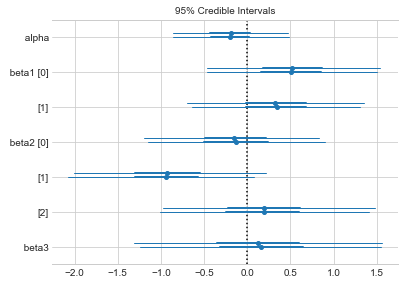

In [21]:
pm.forestplot(m_03.trace,
              varnames=['alpha', 'beta1', 'beta2', 'beta3'],
              rhat=False)
None

In [22]:
with pm.Model() as m_04:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1, shape=2)
    beta2 = pm.Normal('beta2', mu=0, sd=1, shape=3)

    score_i = pm.Deterministic(
        'score',
        wines.score.mean()
        + alpha
        + beta1[0] * wines.judge_amer.values
        + beta1[1] * wines.flight_red.values
        + beta2[0] * (wines.wine_amer.values * wines.judge_amer.values)
        + beta2[1] * (wines.wine_amer.values * wines.flight_red.values)
        + beta2[2] * (wines.judge_amer.values * wines.flight_red.values)
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    score_obs = pm.Normal('score_obs', mu=score_i, sd=sigma,
                          observed=wines.score.values)
    
    m_04.name = 'second level interaction'
    m_04.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:24<00:00, 491.45draws/s]


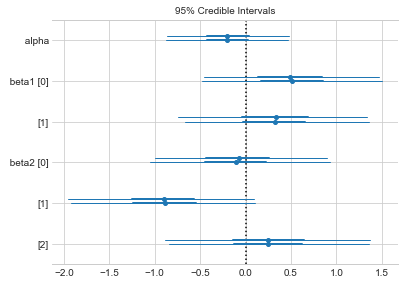

In [24]:
pm.forestplot(m_04.trace,
              varnames=['alpha', 'beta1', 'beta2'],
              rhat=False)
None

In [29]:
with pm.Model() as m_05:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1, shape=2)
    beta2 = pm.Normal('beta2', mu=0, sd=1, shape=2)

    score_i = pm.Deterministic(
        'score',
        wines.score.mean()
        + alpha
        + beta1[0] * wines.judge_amer.values
        + beta1[1] * wines.flight_red.values
        + beta2[0] * (wines.wine_amer.values * wines.flight_red.values)
        + beta2[1] * (wines.judge_amer.values * wines.flight_red.values)
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    score_obs = pm.Normal('score_obs', mu=score_i, sd=sigma,
                          observed=wines.score.values)
    
    m_05.name = 'second level interaction, v2'
    m_05.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:21<00:00, 551.70draws/s]


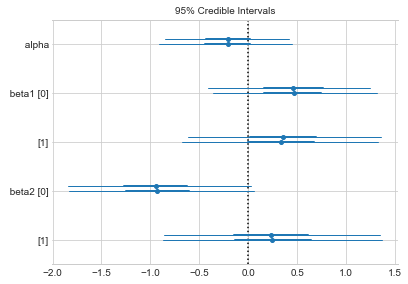

In [30]:
pm.forestplot(m_05.trace,
              varnames=['alpha', 'beta1', 'beta2'],
              rhat=False)
None

In [31]:
pm.compare({
    m_01: m_01.trace,
    m_02: m_02.trace,
    m_03: m_03.trace,
    m_04: m_04.trace,
    m_05: m_05.trace,
})

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
"second level interaction, v2",864.67,4.65,0,1,17.19,0,0
second level interaction,866.17,5.31,1.5,0,17.07,0.33,0
full interaction,866.45,6.59,1.78,0,17.46,2.29,0
"full interaction, v3",866.64,5.63,1.97,0,17.16,0.37,0
"full interaction, v2",867.83,6.15,3.16,0,17.16,0.42,0


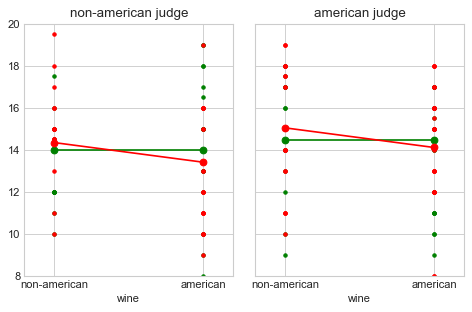

In [66]:
tmp = agg_prediction(m_05.trace['score'], wines,
                     ['wine_amer', 'judge_amer', 'flight_red'], summarize())

fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=80, sharey=True)

for j_amer, title in zip((0, 1), ('non-american', 'american')):
    ax = axes[j_amer]

    for flight, c in zip((0, 1), ('g', 'r')):
        sub = tmp[(tmp.judge_amer == j_amer) & (tmp.flight_red == flight)]
        data_sub = wines[(wines.judge_amer == j_amer) & (wines.flight_red == flight)]

        ax.scatter(data_sub.wine_amer, data_sub.score,
                   c=c, marker='.')

        ax.plot(sub.wine_amer, sub.mean_, c=c, marker='o')
        
        ax.set(xticks=[0, 1], xticklabels=['non-american', 'american'],
               xlabel='wine', title=f'{title} judge',
               xlim=(-.2, 1.2), ylim=(8, 20))
        
fig.tight_layout()
None

* American judges give better scores
* Non-american red wines score better than non-american white wines
* American white wines score better than American red wines
* White whines score about the same regardless of origin

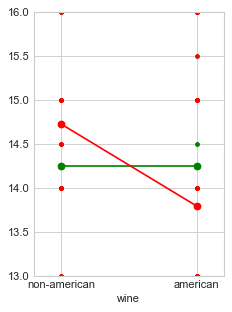

In [67]:
tmp = agg_prediction(m_05.trace['score'], wines,
                     ['wine_amer', 'flight_red'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(3, 4), dpi=80, sharey=True)


for flight, c in zip((0, 1), ('g', 'r')):
    sub = tmp[(tmp.flight_red == flight)]
    data_sub = wines[(wines.flight_red == flight)]

    ax.scatter(data_sub.wine_amer, data_sub.score,
               c=c, marker='.')

    ax.plot(sub.wine_amer, sub.mean_, c=c, marker='o')

    ax.set(xticks=[0, 1], xticklabels=['non-american', 'american'],
           xlabel='wine',
           xlim=(-.2, 1.2), ylim=(13, 16))
        
fig.tight_layout()
None